In [1]:
# Import libraries
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import generate_quantum_dataset as gqd

In [2]:
# Import datasets

# sep_data = th.load('../datasets/sep_states.pt')

# ent_data = th.load('../datasets/ent_states.pt')

N_states = 3000

sep_data = th.tensor(gqd.generate_separable_states(10, N_states), dtype=th.complex64)
ent_data = th.tensor(gqd.generate_entangled_states(N_states), dtype=th.complex64)

th.save(sep_data, '../datasets/sep_states.pt')
th.save(ent_data, '../datasets/ent_states.pt')

In [3]:
print("Any entangled data in the separable dataset?: ", any(gqd.is_entangled(sep_data[i].numpy()) for i in range(N_states)))
print("Are all the data in the entangled dataset entangled?: ", all(gqd.is_entangled(ent_data[i].numpy()) for i in range(N_states)))

Any entangled data in the separable dataset?:  False
Are all the data in the entangled dataset entangled?:  True


In [4]:
sep_data_flattened = sep_data.reshape(sep_data.shape[0], -1)
ent_data_flattened = ent_data.reshape(ent_data.shape[0], -1)

sep_data_flattened.shape

torch.Size([3000, 16])

In [5]:
sep_data_pair = th.stack((sep_data.real, sep_data.imag), dim = 1)
ent_data_pair = th.stack((ent_data.real, ent_data.imag), dim = 1)

sep_data_pair.shape, ent_data_pair.shape

(torch.Size([3000, 2, 4, 4]), torch.Size([3000, 2, 4, 4]))

In [6]:
BATCH_SIZE = 64

sep_train_loader = DataLoader(sep_data_pair, batch_size=BATCH_SIZE, shuffle=True)
ent_train_loader = DataLoader(ent_data_pair, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
N_states = 3000

sep_data = th.tensor(gqd.generate_separable_states(10, N_states), dtype=th.complex64)
ent_data = th.tensor(gqd.generate_entangled_states(N_states), dtype=th.complex64)

print("Any entangled data in the separable dataset?: ", any(gqd.is_entangled(sep_data[i].numpy()) for i in range(N_states)))
print("Are all the data in the entangled dataset entangled?: ", all(gqd.is_entangled(ent_data[i].numpy()) for i in range(N_states)))

sep_data_pair = th.stack((sep_data.real, sep_data.imag), dim = 1)
ent_data_pair = th.stack((ent_data.real, ent_data.imag), dim = 1)
sep_test_loader = DataLoader(sep_data_pair, batch_size=BATCH_SIZE, shuffle=True)
ent_test_loader = DataLoader(ent_data_pair, batch_size=BATCH_SIZE, shuffle=True)

Any entangled data in the separable dataset?:  False
Are all the data in the entangled dataset entangled?:  True


In [8]:
class VAE_fc(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VAE_fc, self).__init__()
        self.enc1 = nn.Linear(input_size, hidden_size[0])
        self.enc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.enc_mu = nn.Linear(hidden_size[1], hidden_size[2])
        self.enc_logvar = nn.Linear(hidden_size[1], hidden_size[2])
        
        self.dec1 = nn.Linear(hidden_size[2], hidden_size[1])
        self.dec2 = nn.Linear(hidden_size[1], hidden_size[0])
        self.dec3 = nn.Linear(hidden_size[0], input_size)
    
    def encoder(self, x):
        x = nn.ReLU()(self.enc1(x))
        x = nn.ReLU()(self.enc2(x))
        
        mu = nn.ReLU()(self.enc_mu(x))
        logvar = nn.ReLU()(self.enc_logvar(x))
        
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = th.exp(0.5 * logvar)
        eps = th.randn_like(std)
        return mu + eps * std 
        
    
    def decoder(self, z):
        z = nn.ReLU()(self.dec1(z))
        z = nn.ReLU()(self.dec2(z))
        z = th.sigmoid(self.dec3(z))
        return z
    
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, z, mu, logvar
    
model = VAE_fc(input_size=4, hidden_size=[10, 5, 2])

# for _, data in enumerate(sep_train_loader):
#     print(data.shape)
#     output = model(data)
#     print(output[0].shape)
#     break

In [9]:
# Define the training function
def train_model(model, train_loader, epochs, optimizer, criterion, device):
    trained_model = model.to(device)
    trained_model.train()
    train_loss = []
    
    for epoch in trange(epochs):
        batch_loss = 0.0
        for data in train_loader:
            # optimizer.zero_grad()
            data = data.to(device)
            decoded, z, mu, logvar = trained_model(data)
            loss = criterion(data, decoded, mu, logvar)
            batch_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # batch_loss /= len(train_loader.dataset)
        train_loss.append(batch_loss)
        
        print(f'Epoch: {epoch + 1}, Loss: {batch_loss:.4f}')
    return trained_model, np.array(train_loss)

def get_test_loss(trained_model, test_loader, criterion, device):
    decoded_data = []
    test_loss = 0.0
    for _, data in enumerate(test_loader):
        data = data.to(device)
        decoded, z, mu, logvar = trained_model(data)
        decoded_data.append(decoded.detach().numpy())
        test_loss += criterion(data, decoded).item()
    # test_loss /= len(test_loader.dataset)
    return test_loss, np.array(decoded_data)

def get_test_loss_KL(trained_model, test_loader, criterion):
    trained_model.eval()
    decoded_data = []
    test_loss = 0.0
    for _, data in enumerate(test_loader):
        decoded, z, mu, logvar = trained_model(data)
        decoded_data.append(decoded.detach().numpy())
        test_loss += criterion(data, decoded, mu, logvar).item()
    # test_loss /= len(test_loader.dataset)
    return test_loss, np.array(decoded_data)

In [10]:
def VAE_loss(input, output, mu, logvar):
    reconstruction_loss = F.mse_loss(output, input, reduction='sum')
    KL_loss = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + 0.5 * KL_loss

In [11]:
EPOCHS = 10
HIDDEN_SIZE = [20, 8, 2]
LEARNING_RATE = 0.0001
INPUT_SIZE = 4
device = 'cpu'

model = VAE_fc(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
optimizer = th.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

trained_model_ent, train_loss_ent = train_model(model = model,
                                                train_loader = ent_train_loader,
                                                epochs = EPOCHS,
                                                optimizer = optimizer,
                                                criterion = VAE_loss,
                                                device = 'cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Loss: 16503.9478
Epoch: 2, Loss: 15810.3596
Epoch: 3, Loss: 15310.4558
Epoch: 4, Loss: 14910.5282
Epoch: 5, Loss: 14508.4519
Epoch: 6, Loss: 14126.4755
Epoch: 7, Loss: 13757.6161
Epoch: 8, Loss: 13386.4763
Epoch: 9, Loss: 13047.7437
Epoch: 10, Loss: 12692.5934


In [26]:
train_loss_ent_model = []
trained_model_ent.eval()
# train_loss_ent_model.append(get_test_loss(trained_model_ent, ent_train_loader, F.mse_loss)[0])
train_loss_ent_model.append(F.mse_loss(ent_train_loader.dataset.to(device), trained_model_ent(ent_train_loader.dataset)[0]).item())
train_loss_ent_model.append(get_test_loss_KL(trained_model_ent, ent_train_loader, VAE_loss)[0])

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_82658/2009938516.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


In [13]:
test_loss_func = F.mse_loss
test_loss_ent_model_ent_data = []
# test_loss_ent_model_ent_data.append(get_test_loss(trained_model_ent.eval(), ent_test_loader, test_loss_func)[0])

test_loss_ent_model_ent_data.append(test_loss_func(ent_test_loader.dataset, trained_model_ent(ent_test_loader.dataset)[0]).item())
test_loss_ent_model_ent_data.append(get_test_loss_KL(trained_model_ent.eval(), ent_test_loader, VAE_loss)[0])

test_loss_ent_model_sep_data = []
# test_loss_ent_model_sep_data.append(get_test_loss(trained_model_ent.eval(), sep_test_loader, test_loss_func)[0])
test_loss_ent_model_sep_data.append(test_loss_func(sep_test_loader.dataset, trained_model_ent(sep_test_loader.dataset)[0]).item())
test_loss_ent_model_sep_data.append(get_test_loss_KL(trained_model_ent.eval(), sep_test_loader, VAE_loss)[0])



test_loss_ent_model_ent_data, test_loss_ent_model_sep_data

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_82658/2009938516.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


([0.13068407773971558, 12562.357040405273],
 [0.11033256351947784, 10608.754745483398])

In [14]:
def get_reconstructed_states(trained_model, input_loader):
    trained_model.eval()
    decoded_data_pair = trained_model(input_loader.dataset)[0].detach().numpy()
    
    decoded_data = np.zeros((decoded_data_pair.shape[0], 4, 4), dtype=np.complex64)

    for i in range(decoded_data_pair.shape[0]):
        decoded_data[i] = decoded_data_pair[i, 0, :, :] + 1j * decoded_data_pair[i, 1, :, :]
    
    return np.array(decoded_data)

def get_accuracy(decoded_data):
    separable = 0
    entangled = 0
    
    for i in range(decoded_data.shape[0]):
        if gqd.is_entangled(decoded_data[i]):
            entangled += 1
        else:
            separable += 1
            
    sep = separable * 100/(separable + entangled)
    ent = entangled * 100/(separable + entangled)
    print(f"Separable: {sep:.2f}%, Entangled: {ent:.2f}%")

In [15]:
reconstructed_ent_model_ent_data = get_reconstructed_states(trained_model_ent, ent_test_loader)
reconstructed_ent_model_sep_data = get_reconstructed_states(trained_model_ent, sep_test_loader)

get_accuracy(reconstructed_ent_model_ent_data), get_accuracy(reconstructed_ent_model_sep_data)

Separable: 4.77%, Entangled: 95.23%
Separable: 5.77%, Entangled: 94.23%


(None, None)

In [16]:
model = VAE_fc(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
optimizer = th.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

trained_model_sep, train_loss_sep = train_model(model = model,
                                                train_loader = sep_train_loader,
                                                epochs = EPOCHS,
                                                optimizer = optimizer,
                                                criterion = VAE_loss,
                                                device = 'cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1, Loss: 17546.5479
Epoch: 2, Loss: 16514.4254
Epoch: 3, Loss: 15829.1787
Epoch: 4, Loss: 15215.3849
Epoch: 5, Loss: 14679.2372
Epoch: 6, Loss: 14124.3522
Epoch: 7, Loss: 13579.2070
Epoch: 8, Loss: 13016.2816
Epoch: 9, Loss: 12413.0173
Epoch: 10, Loss: 11900.0273


In [17]:
train_loss_sep_model = []
trained_model_sep.eval()
# train_loss_sep_model.append(get_test_loss(trained_model_sep, sep_train_loader, F.mse_loss)[0])
train_loss_sep_model.append(F.mse_loss(sep_train_loader.dataset, trained_model_sep(sep_train_loader.dataset)[0]).item())
train_loss_sep_model.append(get_test_loss_KL(trained_model_sep, sep_train_loader, VAE_loss)[0])

train_loss_sep_model

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_82658/2009938516.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


[0.12085774540901184, 11567.67903137207]

In [18]:
test_loss_sep_model_ent_data = []
# test_loss_sep_model_ent_data.append(get_test_loss(trained_model_sep, ent_test_loader, test_loss_func)[0])
test_loss_sep_model_ent_data.append(test_loss_func(ent_test_loader.dataset, trained_model_sep(ent_test_loader.dataset)[0]).item())
test_loss_sep_model_ent_data.append(get_test_loss_KL(trained_model_sep, ent_test_loader, VAE_loss)[0])

test_loss_sep_model_sep_data = []
# test_loss_sep_model_sep_data.append(get_test_loss(trained_model_sep, sep_test_loader, test_loss_func)[0])
test_loss_sep_model_sep_data.append(test_loss_func(sep_test_loader.dataset, trained_model_sep(sep_test_loader.dataset)[0]).item())
test_loss_sep_model_sep_data.append(get_test_loss_KL(trained_model_sep, sep_test_loader, VAE_loss)[0])

test_loss_sep_model_ent_data, test_loss_sep_model_sep_data

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_82658/2009938516.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


([0.13674511015415192, 13119.644958496094],
 [0.12075873464345932, 11582.101959228516])

In [19]:
print(test_loss_ent_model_ent_data, test_loss_ent_model_sep_data)
print(test_loss_sep_model_ent_data, test_loss_sep_model_sep_data)

[0.13068407773971558, 12562.357040405273] [0.11033256351947784, 10608.754745483398]
[0.13674511015415192, 13119.644958496094] [0.12075873464345932, 11582.101959228516]


In [20]:
reconstructed_sep_model_ent_data = get_reconstructed_states(trained_model_sep, ent_test_loader)
reconstructed_sep_model_sep_data = get_reconstructed_states(trained_model_sep, sep_test_loader)

get_accuracy(reconstructed_sep_model_ent_data), get_accuracy(reconstructed_sep_model_sep_data)

Separable: 5.37%, Entangled: 94.63%
Separable: 5.20%, Entangled: 94.80%


(None, None)

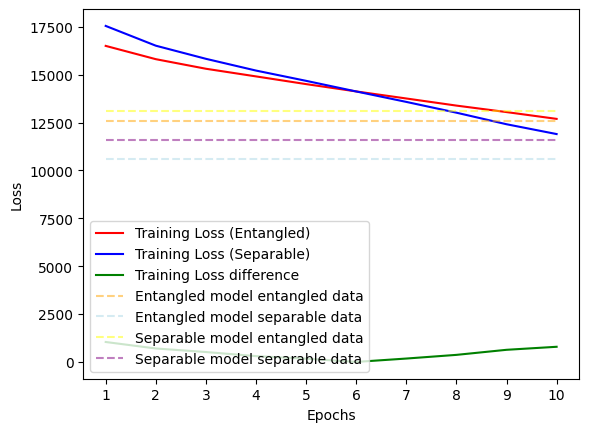

In [21]:
x_values = np.arange(1, len(train_loss_ent) + 1)
x_ticks = np.linspace(1, len(train_loss_ent), 10, dtype=int)

plt.plot(x_values, train_loss_ent, label='Training Loss (Entangled)', color='red')
plt.plot(x_values, train_loss_sep, label='Training Loss (Separable)', color = 'blue')
plt.plot(x_values, np.abs(train_loss_ent - train_loss_sep), label='Training Loss difference', color = 'green')
plt.plot(x_values, test_loss_ent_model_ent_data[1] * np.ones(len(x_values)), label='Entangled model entangled data', alpha=0.5, linestyle='--', color = 'orange')
plt.plot(x_values, test_loss_ent_model_sep_data[1] * np.ones(len(x_values)), label='Entangled model separable data', alpha=0.5, linestyle='--', color = 'lightblue')
plt.plot(x_values, test_loss_sep_model_ent_data[1] * np.ones(len(x_values)), label='Separable model entangled data', alpha=0.5, linestyle='--', color = 'yellow')
plt.plot(x_values, test_loss_sep_model_sep_data[1] * np.ones(len(x_values)), label='Separable model separable data', alpha=0.5, linestyle='--', color = 'purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(x_ticks)
plt.legend()

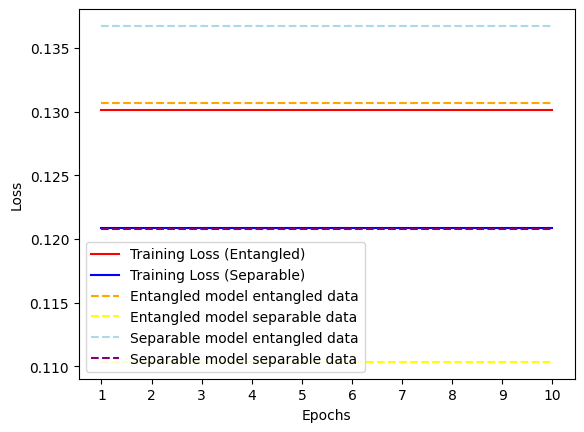

In [25]:
plt.plot(x_values, train_loss_ent_model[0] * np.ones(len(x_values)), label='Training Loss (Entangled)', color = 'red')
plt.plot(x_values, train_loss_sep_model[0]* np.ones(len(x_values)), label='Training Loss (Separable)', color = 'blue')
plt.plot(x_values, test_loss_ent_model_ent_data[0] * np.ones(len(x_values)), label='Entangled model entangled data', linestyle='--', color = 'orange')
plt.plot(x_values, test_loss_ent_model_sep_data[0] * np.ones(len(x_values)), label='Entangled model separable data', linestyle='--', color = 'yellow')
plt.plot(x_values, test_loss_sep_model_ent_data[0] * np.ones(len(x_values)), label='Separable model entangled data', linestyle='--', color = 'lightblue')
plt.plot(x_values, test_loss_sep_model_sep_data[0] * np.ones(len(x_values)), label='Separable model separable data', linestyle='--', color = 'purple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(x_ticks)
plt.legend()

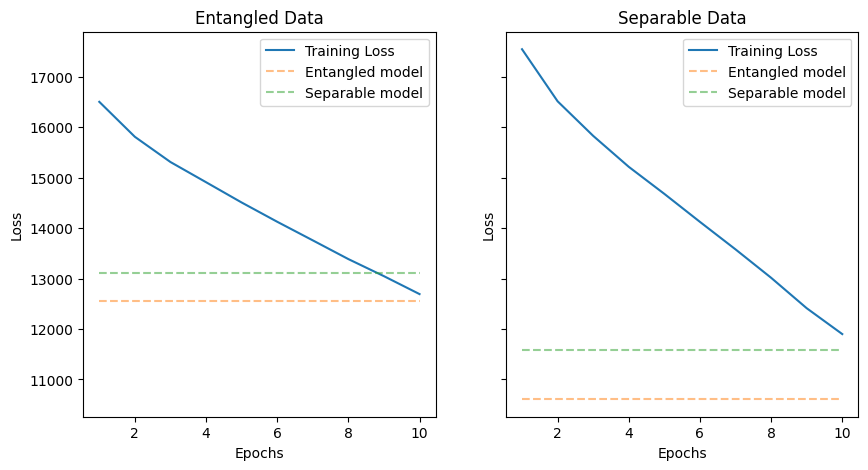

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
skip_values = 0
x_values = np.arange( skip_values + 1, len(train_loss_ent) + 1)

axs[0].plot(x_values, train_loss_ent[skip_values:], label='Training Loss')
axs[0].plot(x_values, test_loss_ent_model_ent_data[1] * np.ones(len(x_values)), label='Entangled model', alpha=0.5, linestyle='--')
axs[0].plot(x_values, test_loss_sep_model_ent_data[1] * np.ones(len(x_values)), label='Separable model', alpha=0.5, linestyle='--')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Entangled Data')
axs[0].legend()
axs[0].set_ylabel('Loss')

axs[1].plot(x_values, train_loss_sep[skip_values:], label='Training Loss')
axs[1].plot(x_values, test_loss_ent_model_sep_data[1] * np.ones(len(x_values)), label='Entangled model', alpha=0.5, linestyle='--')
axs[1].plot(x_values, test_loss_sep_model_sep_data[1] * np.ones(len(x_values)), label='Separable model', alpha=0.5, linestyle='--')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Separable Data')
axs[1].legend()
axs[1].set_ylabel('Loss')


plt.savefig('../Figures/VAE_loss_4.png')

Text(0, 0.5, 'Loss')

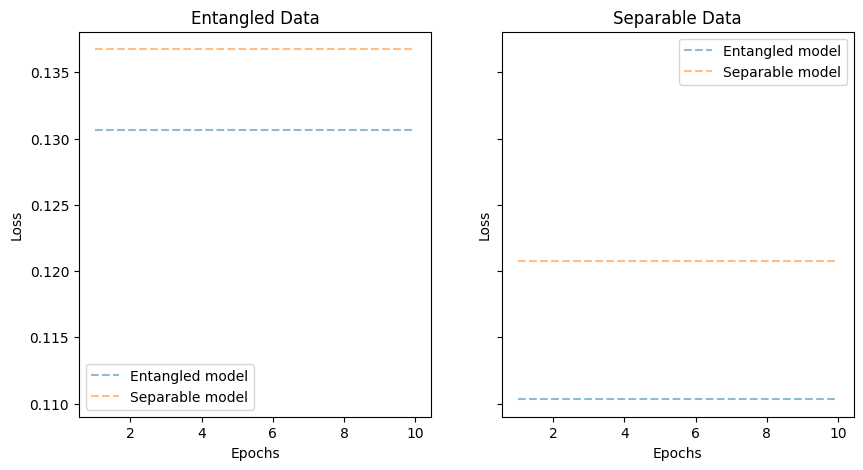

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
skip_values = 0
x_values = np.arange( skip_values + 1, len(train_loss_ent) + 1)

# axs[0].plot(x_values, train_loss_ent[skip_values:], label='Training Loss')
axs[0].plot(x_values, test_loss_ent_model_ent_data[0] * np.ones(len(x_values)), label='Entangled model', alpha=0.5, linestyle='--')
axs[0].plot(x_values, test_loss_sep_model_ent_data[0] * np.ones(len(x_values)), label='Separable model', alpha=0.5, linestyle='--')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Entangled Data')
axs[0].legend()
axs[0].set_ylabel('Loss')

# axs[1].plot(x_values, train_loss_sep[skip_values:], label='Training Loss')
axs[1].plot(x_values, test_loss_ent_model_sep_data[0] * np.ones(len(x_values)), label='Entangled model', alpha=0.5, linestyle='--')
axs[1].plot(x_values, test_loss_sep_model_sep_data[0] * np.ones(len(x_values)), label='Separable model', alpha=0.5, linestyle='--')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Separable Data')
axs[1].legend()
axs[1].set_ylabel('Loss')


# plt.savefig('../Figures/VAE_loss_4.png')